In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import  torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset, DatasetDict, load_metric
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
# Load dataset
cleaned_df = pd.read_csv('suicide_detection_full_cleaned.csv') 
cleaned_df.head()

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fucking god annoying
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam struggle year afraid past year...


In [3]:
cleaned_df.text.dtype

dtype('O')

In [4]:
cleaned_df.head()

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fucking god annoying
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam struggle year afraid past year...


In [90]:
df=cleaned_df
SEED=91



In [5]:
cleaned_df=cleaned_df.drop(['text'] , axis =1)

In [6]:
cleaned_df.head()

,class,cleaned_text
0,suicide,sex wife threaten suicide recently leave wife ...
1,non-suicide,weird not affect compliment come know girl fee...
2,non-suicide,finally hear bad year swear fucking god annoying
3,suicide,need help help cry hard
4,suicide,lose hello adam struggle year afraid past year...


In [7]:
class_ = cleaned_df.pop('class')

In [8]:
cleaned_df.insert(1,'class',class_)

In [9]:
cleaned_df

,cleaned_text,class
0,sex wife threaten suicide recently leave wife ...,suicide
1,weird not affect compliment come know girl fee...,non-suicide
2,finally hear bad year swear fucking god annoying,non-suicide
3,need help help cry hard,suicide
4,lose hello adam struggle year afraid past year...,suicide
...,...,...
232069,not like rock not go,non-suicide
232070,tell friend not lonely deprive buy little nigh...,non-suicide
232071,pee probably taste like salty tea drink pee co...,non-suicide
232072,usual stuff find not post sympathy pity know f...,suicide


In [10]:
print(cleaned_df['cleaned_text'].isnull().sum())

146


In [12]:
# Drop missing values in the cleaned_text column
cleaned_df = cleaned_df.dropna(subset=['cleaned_text'])

In [11]:
# Check for non-string values
print(cleaned_df['cleaned_text'].apply(lambda x: isinstance(x, str)).sum())

231928


# copy created for cleaned df , if need be restart from here

In [14]:
df=cleaned_df

In [16]:
SEED=90

In [17]:
# Split dataset into train, validation and test sets
train, temp = train_test_split(df,
                               random_state=SEED,
                               test_size=0.2,
                               stratify=df['class'])

val, test = train_test_split(temp,
                             random_state=SEED,
                             test_size=0.5,
                             stratify=temp['class'])

In [18]:
test_labels = test['class']
train_labels= train['class']
val_labels = val['class']

In [19]:
test_labels

198890    non-suicide
146636        suicide
106555    non-suicide
197766    non-suicide
79126     non-suicide
             ...     
222585    non-suicide
46840         suicide
29999     non-suicide
66424     non-suicide
110870    non-suicide
Name: class, Length: 23193, dtype: object

In [20]:
train = train.drop(['class'] , axis = 1 )
temp = temp.drop(['class'] , axis = 1 )
val = val.drop(['class'] , axis = 1 )
test = test.drop(['class'] , axis = 1 )

In [21]:
#train

In [22]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("Models/bert")

In [23]:
# Specify GPU
device = torch.device("cuda")

In [24]:
print(device)

cuda


In [25]:
train.cleaned_text.dtype

dtype('O')

In [26]:
def dataset_conversion(train, test, val):
  """Converts pandas dataframe to Dataset."""

  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)
  val.reset_index(drop=True, inplace=True)

  train_dataset = Dataset.from_pandas(train)
  test_dataset = Dataset.from_pandas(test)
  val_dataset = Dataset.from_pandas(val)

  return DatasetDict({"train": train_dataset,
                      "test": test_dataset,
                      "val": val_dataset})

raw_datasets = dataset_conversion(train, test, val)

In [27]:
def tokenize_function(dataset):
    return tokenizer(dataset["cleaned_text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/185542 [00:00<?, ? examples/s]

Map:   0%|          | 0/23193 [00:00<?, ? examples/s]

Map:   0%|          | 0/23193 [00:00<?, ? examples/s]

In [28]:
# Tokenise datasets
SAMPLE_SIZE = 20
small_train_dataset = tokenized_datasets["train"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))
small_val_dataset = tokenized_datasets["val"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))

full_train_dataset = tokenized_datasets["train"]
full_test_dataset = tokenized_datasets["test"]
full_val_dataset = tokenized_datasets["val"]

In [29]:
small_train_dataset

Dataset({
    features: ['cleaned_text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 20
})

In [30]:
# Load pre-trained model and tokenizer
model =BertModel.from_pretrained('Models/bert') 
model.eval()  # Set the model to evaluation mode
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [33]:
def generate_bert_embeddings(dataset, batch_size=8):
    embeddings = []

    for i in range(0, len(dataset), batch_size):
        #print(batch_size)
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

        # Tokenize the batch
        inputs = tokenizer(batch['cleaned_text'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] token embeddings

        # Append to the list
        embeddings.append(batch_embeddings)

        # Clear GPU memory after processing each batch
        del inputs
        torch.cuda.empty_cache()

    # Concatenate all batch embeddings
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings


In [34]:
# Assuming 'tokenized_dataset' is your fully tokenized dataset (e.g., from the Hugging Face datasets library)
# The dataset might be in a format like a dictionary or a dataset object, adjust accordingly.
train_embeddings = generate_bert_embeddings(full_train_dataset)

d:\python\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [39]:
test_embeddings=generate_bert_embeddings(full_test_dataset)
validation_embeddings=generate_bert_embeddings(full_val_dataset)

In [35]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the emotion detection model and tokenizer
emotion_model_name = "Models/RoBERTa"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name)
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
emotion_model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [36]:

# Function to get emotion embeddings in batches
def get_emotion_embeddings_batched(dataset, batch_size=32):
    emotion_embeddings = []

    for i in range(0, len(dataset), batch_size):
        batch_texts = dataset['cleaned_text'][i:i+batch_size]
        
        # Tokenize the text data
        tokens = emotion_tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        tokens = {key: val.to(device) for key, val in tokens.items()}
        
        # Generate emotion vectors
        with torch.no_grad():
            outputs = emotion_model(**tokens)
            emotion_vectors = outputs.logits
        
        # Move tensors to CPU and convert to numpy arrays
        emotion_embeddings.extend(emotion_vectors.cpu().numpy())

    return emotion_embeddings


In [37]:

# Generate emotion embeddings for the train dataset
train_emotion_embeddings = get_emotion_embeddings_batched(full_train_dataset)
val_emotion_embeddings = get_emotion_embeddings_batched(full_val_dataset)
test_emotion_embeddings=get_emotion_embeddings_batched(full_test_dataset)

In [40]:

# Assuming train_bert_embeddings and train_emotion_embeddings are your BERT and emotion embeddings
# Convert lists to numpy arrays
train_bert_embeddings = np.array(train_embeddings)
train_emotion_embeddings = np.array(train_emotion_embeddings)
test_bert_embeddings=np.array(test_embeddings)
test_emotion_embeddings=np.array(test_emotion_embeddings)
val_bert_embeddings=np.array(validation_embeddings)
val_emotion_embeddings=np.array(val_emotion_embeddings)

# Concatenate the embeddings along the last dimension
train_combined_embeddings = np.concatenate((train_bert_embeddings, train_emotion_embeddings), axis=1)
val_combined_embeddings = np.concatenate((val_bert_embeddings, val_emotion_embeddings), axis=1)
test_combined_embeddings = np.concatenate((test_bert_embeddings, test_emotion_embeddings), axis=1)



In [41]:
# You can check the shape of the combined embeddings
print(train_combined_embeddings.shape)
print (val_combined_embeddings.shape)
print(test_combined_embeddings.shape)

(185542, 775)
(23193, 775)
(23193, 775)


In [42]:
# Define a mapping from text labels to numeric labels
label_mapping = {'suicide': 1, 'non-suicide': 0}

# Apply the mapping to convert text labels to numeric labels
train_labels = train_labels.map(label_mapping).values
val_labels = val_labels.map(label_mapping).values
test_labels=test_labels.map(label_mapping).values

In [43]:


# Convert the labels to a PyTorch tensor
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Ensure the combined embeddings are in the correct format
train_combined_embeddings = np.array(train_combined_embeddings, dtype=np.float32)
val_combined_embeddings = np.array(val_combined_embeddings, dtype=np.float32)
test_combined_embeddings = np.array(test_combined_embeddings, dtype=np.float32)

# Convert the combined embeddings to a PyTorch tensor
train_combined_embeddings_tensor = torch.tensor(train_combined_embeddings, dtype=torch.float32)
val_combined_embeddings_tensor = torch.tensor(val_combined_embeddings, dtype=torch.float32)
test_combined_embeddings_tensor = torch.tensor(test_combined_embeddings, dtype=torch.float32)

# Create a TensorDataset
train_dataset = TensorDataset(train_combined_embeddings_tensor, train_labels)
val_dataset = TensorDataset(val_combined_embeddings_tensor, val_labels)
test_dataset=TensorDataset(test_combined_embeddings_tensor,test_labels)

# Create a DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Check the size of the data loader
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))



5799
363
363


In [44]:
print(train_combined_embeddings_tensor.shape)

torch.Size([185542, 775])


In [45]:
torch.save(train_combined_embeddings_tensor, 'train_embeddings.pt')
torch.save(val_combined_embeddings_tensor, 'val_embeddings.pt')
torch.save(test_combined_embeddings_tensor, 'test_embeddings.pt')


In [46]:
# Assuming these tensors are already created
torch.save(train_labels, 'train_labels_tensor.pt')
torch.save(val_labels, 'val_labels_tensor.pt')
torch.save(test_labels, 'test_labels_tensor.pt')


In [48]:
test_labels.unique()


tensor([0, 1])

In [49]:
from collections import Counter
class_distribution = Counter(test_labels)
print(class_distribution)

Counter({tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 

In [50]:
t = test_labels

In [51]:
from collections import Counter

# Assuming test_loader is your DataLoader for the test dataset
all_labels = []

for _, labels in test_loader:
    all_labels.extend(t.tolist())

class_distribution = Counter(all_labels)
print(class_distribution)

Counter({1: 4210800, 0: 4208259})


In [52]:
c = Counter(t)
print(c)

Counter({tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 

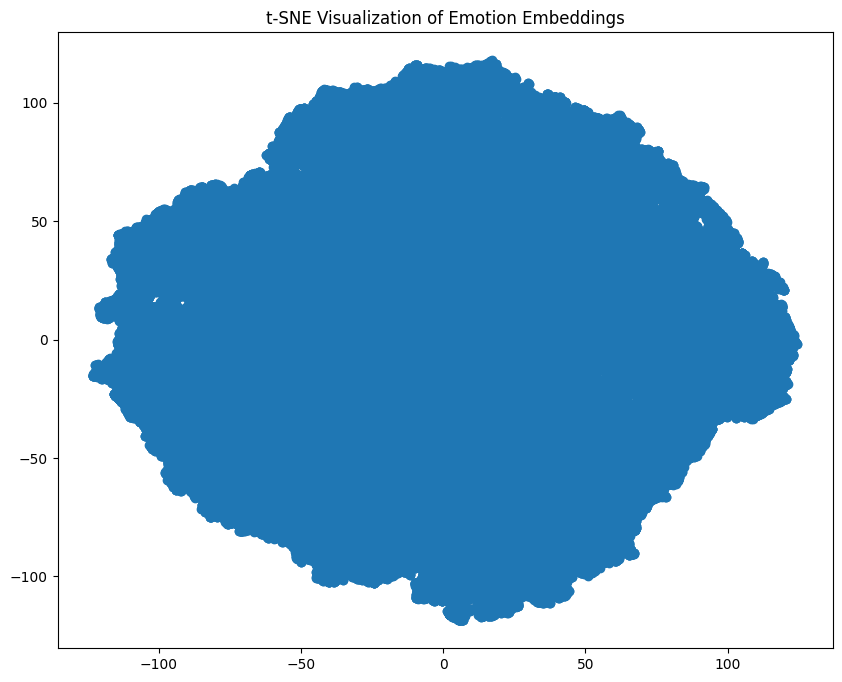

In [ ]:
#import numpy as np
#from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt

# Convert list of embeddings into a 2D array
#embeddings_array = np.vstack(cleaned_df['emotion_embedding'].values)

# Use t-SNE to reduce dimensionality
#tsne = TSNE(n_components=2, random_state=42)
#embeddings_2d = tsne.fit_transform(embeddings_array)

# Plot the embeddings
#plt.figure(figsize=(10, 8))
#plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
#plt.title('t-SNE Visualization of Emotion Embeddings')
#plt.show()


In [ ]:
# Save as a CSV file
#cleaned_df.to_csv('emotion_embeddings.csv', index=False)

# Save as a NumPy file
#np.save('emotion_embeddings.npy', np.vstack(cleaned_df['emotion_embedding'].values))


In [ ]:
#embeddings_array = np.vstack(cleaned_df['emotion_embedding'].values)
#print("Mean:", np.mean(embeddings_array, axis=0))
#print("Standard Deviation:", np.std(embeddings_array, axis=0))


Mean: [ 0.33387998 -2.084758   -0.26898956  0.02085253  0.48978883  1.7395204
  0.04494886]
Standard Deviation: [1.6983875 1.366979  2.2504158 1.6663353 1.559372  1.979979  1.3478892]
